In [5]:
# connect google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
import random
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings(action='ignore')

#설정
CFG = {
    'SR': 16000, # 샘플링 레이트
    'N_MFCC': 32, # MFCC 벡터를 추출할 개수
    'SEED': 42, # 시드 값
    #'N_NEIGHBORS': 5, # KNN에서 사용할 이웃의 수
    #'METRIC': 'euclidean' # 거리 측도
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

# Seed 고정
seed_everything(CFG['SEED'])

#wav에서 MFCC 특징 추출
def get_extended_mfcc_feature(df):
    features = []
    for path in tqdm(df['path']):
      # Google Drive 경로 추가
        full_path = f'/content/drive/My Drive/{path}'
        y, sr = librosa.load(full_path, sr=CFG['SR'])
        # (원래:) y, sr = librosa.load(path, sr=CFG['SR'])
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

        features.append(np.mean(mfcc, axis=1).tolist() +
                        np.mean(chroma, axis=1).tolist() +
                        np.mean(mel, axis=1).tolist() +
                        np.mean(contrast, axis=1).tolist() +
                        np.mean(tonnetz, axis=1).tolist())

    columns = ['mfcc_'+str(x) for x in range(1, CFG['N_MFCC']+1)] + \
              ['chroma_'+str(x) for x in range(1, 13)] + \
              ['mel_'+str(x) for x in range(1, 129)] + \
              ['contrast_'+str(x) for x in range(1, 8)] + \
              ['tonnetz_'+str(x) for x in range(1, 7)]

    extended_df = pd.DataFrame(features, columns=columns)
    return extended_df

#데이터 불러오기
train_df = pd.read_csv('/content/drive/My Drive/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/test.csv')
train_y = train_df['label'] # train_df에서 레이블 데이터를 가져옴
submission = pd.read_csv('/content/drive/My Drive/sample_submission.csv')

#특징  추출
train_x = get_extended_mfcc_feature(train_df)
test_x = get_extended_mfcc_feature(test_df)

# train_x, train_y를 훈련 데이터와 검증 데이터로 분할
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, test_size=0.2, random_state=CFG['SEED'])

"""
# 표준화 스케일러
scaler = StandardScaler()

# 훈련 데이터에 대해 fit_transform을 적용하고, 검증 데이터에 대해서는 transform을 적용
X_train_scaled = scaler.fit_transform(X_train)
#fit_transform (훈련 데이터에 적용): fit_transform은 두 단계를 포함
#첫 번째 단계에서는 fit 단계로, 훈련 데이터의 평균과 표준편차와 같은 통계적 특성을 계산
#두 번째 단계에서는 transform 단계로, 계산된 통계적 특성(평균과 표준편차)을 사용하여 데이터를 표준화
#(즉, 각 특성의 평균을 0, 표준편차를 1로 조정). 이 과정을 통해 모델이 훈련 데이터에 대해 학습을 할 때,
#모든 특성이 동일한 스케일로 조정되어 있으므로 학습 효율이 향상

X_val_scaled = scaler.transform(X_val)
#transform (검증 데이터에 적용): 검증 데이터에는 transform만 적용
#검증 데이터를 훈련 데이터와 동일한 방식으로 변환하기 위해, 훈련 데이터로부터 계산된 평균과 표준편차를 사용하여
#검증 데이터를 표준화하는 과정. 여기서 훈련 데이터에서 얻은 통계치를 사용
#이렇게 함으로써, 검증 데이터가 훈련 과정에 영향을 주지 않으며, 모델의 일반화 능력을 더 정확하게 평가

# 테스트 데이터도 스케일링
test_x_scaled = scaler.transform(test_x)
"""
# 하이퍼파라미터 튜닝을 위한 그리드 서치
params = {
    'n_neighbors': [20, 24, 30,40, 50, 60,70],
    'metric': ['euclidean', 'manhattan', 'minkowski', 'cosine']
}

k_values = [3, 5, 10]
for k in k_values:
    print(f"K={k}에 대한 교차 검증 진행")
    cv = KFold(n_splits=k, shuffle=True, random_state=CFG['SEED'])
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, params, cv=cv, scoring='accuracy')
    clf.fit(X_train, y_train)

    # 최적의 하이퍼파라미터와 그 때의 성능 출력
    print("Best parameters:", clf.best_params_)
    print("Best accuracy:", clf.best_score_)

# 최적의 설정을 사용한 모델로 스케일링된 테스트 데이터 예측
preds = clf.best_estimator_.predict(test_x)

# 결과 저장
submission['label'] = preds
submission.to_csv('/content/drive/My Drive/knn_lastqqq.csv', index=False)

"""
seed를 42로 설정, 8:2 분할과 scaling은 안 했을때:

K=3에 대한 교차 검증 진행중...
Best parameters: {'metric': 'manhattan', 'n_neighbors': 24}
Best accuracy: 0.4263147370525895

K=5에 대한 교차 검증 진행중...
Best parameters: {'metric': 'manhattan', 'n_neighbors': 20}
Best accuracy: 0.4377110889110889

K=10에 대한 교차 검증 진행중...
Best parameters: {'metric': 'manhattan', 'n_neighbors': 20}
Best accuracy: 0.43611656686626754

seed를 0로 설정, 8:2 분할과 scaling은 안 했을때:


K=3에 대한 교차 검증 진행
Best parameters: {'metric': 'manhattan', 'n_neighbors': 30}
Best accuracy: 0.4175164967006599
K=5에 대한 교차 검증 진행
Best parameters: {'metric': 'manhattan', 'n_neighbors': 20}
Best accuracy: 0.4249190809190809
K=10에 대한 교차 검증 진행
Best parameters: {'metric': 'manhattan', 'n_neighbors': 20}
Best accuracy: 0.4309225548902195

스케일링 없이. seed 고정
K=3에 대한 교차 검증 진행
Best parameters: {'metric': 'manhattan', 'n_neighbors': 24}
Best accuracy: 0.4115020509250251
K=5에 대한 교차 검증 진행
Best parameters: {'metric': 'manhattan', 'n_neighbors': 30}
Best accuracy: 0.425
K=10에 대한 교차 검증 진행
Best parameters: {'metric': 'manhattan', 'n_neighbors': 30}
Best accuracy: 0.42475000000000007
"""

"""
seed:42, 8:2, scaling
K=3에 대한 교차 검증 진행
Best parameters: {'metric': 'cosine', 'n_neighbors': 20}
Best accuracy: 0.3990011745815014
K=5에 대한 교차 검증 진행
Best parameters: {'metric': 'cosine', 'n_neighbors': 20}
Best accuracy: 0.413
K=10에 대한 교차 검증 진행
Best parameters: {'metric': 'cosine', 'n_neighbors': 20}
Best accuracy: 0.4175

--> 스케일링을 한 경우의 정확도가 스케일링을 하지 않았을 때보다 전반적으로 낮음.
이는 스케일링 방법이나 적용된 피처에 따라 다를 수 있으며
MFCC 특성은 자체적으로 비교적 일관된 범위를 가지고 있어서, 특정 스케일링 방법이 오히려 성능 저하를 일으킬 수도 있습니다.
다른 스케일링 방법을 시도해보거나, 스케일링 없이 특정 피처만 선택하는 등의 접근 방식을 고려해볼 수 있음


--> 4.3정도가 최대
"""


  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/1881 [00:00<?, ?it/s]

K=3에 대한 교차 검증 진행
Best parameters: {'metric': 'manhattan', 'n_neighbors': 24}
Best accuracy: 0.4115020509250251
K=5에 대한 교차 검증 진행
Best parameters: {'metric': 'manhattan', 'n_neighbors': 30}
Best accuracy: 0.425
K=10에 대한 교차 검증 진행
Best parameters: {'metric': 'manhattan', 'n_neighbors': 30}
Best accuracy: 0.42475000000000007


"\nseed:42, 8:2, scaling\nK=3에 대한 교차 검증 진행\nBest parameters: {'metric': 'cosine', 'n_neighbors': 20}\nBest accuracy: 0.3990011745815014\nK=5에 대한 교차 검증 진행\nBest parameters: {'metric': 'cosine', 'n_neighbors': 20}\nBest accuracy: 0.413\nK=10에 대한 교차 검증 진행\nBest parameters: {'metric': 'cosine', 'n_neighbors': 20}\nBest accuracy: 0.4175\n\n--> 스케일링을 한 경우의 정확도가 스케일링을 하지 않았을 때보다 전반적으로 낮음. \n이는 스케일링 방법이나 적용된 피처에 따라 다를 수 있으며 \nMFCC 특성은 자체적으로 비교적 일관된 범위를 가지고 있어서, 특정 스케일링 방법이 오히려 성능 저하를 일으킬 수도 있습니다. \n다른 스케일링 방법을 시도해보거나, 스케일링 없이 특정 피처만 선택하는 등의 접근 방식을 고려해볼 수 있음\n\n"

In [ ]:
import random
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
import librosa
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings(action='ignore')

#설정
CFG = {
    'SR': 16000, # 샘플링 레이트
    'N_MFCC': 32, # MFCC 벡터를 추출할 개수
    'SEED': 42, # 시드 값
    #'N_NEIGHBORS': 5, # KNN에서 사용할 이웃의 수
    #'METRIC': 'euclidean' # 거리 측도
}

#wav에서 MFCC 특징 추출
def get_extended_mfcc_feature(df):
    features = []
    for path in tqdm(df['path']):
      # Google Drive 경로 추가
        full_path = f'/content/drive/My Drive/{path}'
        y, sr = librosa.load(full_path, sr=CFG['SR'])
        # (원래:) y, sr = librosa.load(path, sr=CFG['SR'])
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])
        chroma = librosa.feature.chroma_stft(y=y, sr=sr)
        mel = librosa.feature.melspectrogram(y=y, sr=sr)
        contrast = librosa.feature.spectral_contrast(y=y, sr=sr)
        tonnetz = librosa.feature.tonnetz(y=y, sr=sr)

        features.append(np.mean(mfcc, axis=1).tolist() +
                        np.mean(chroma, axis=1).tolist() +
                        np.mean(mel, axis=1).tolist() +
                        np.mean(contrast, axis=1).tolist() +
                        np.mean(tonnetz, axis=1).tolist())

    columns = ['mfcc_'+str(x) for x in range(1, CFG['N_MFCC']+1)] + \
              ['chroma_'+str(x) for x in range(1, 13)] + \
              ['mel_'+str(x) for x in range(1, 129)] + \
              ['contrast_'+str(x) for x in range(1, 8)] + \
              ['tonnetz_'+str(x) for x in range(1, 7)]

    extended_df = pd.DataFrame(features, columns=columns)
    return extended_df

#데이터 불러오기
train_df = pd.read_csv('/content/drive/My Drive/train.csv')
test_df = pd.read_csv('/content/drive/My Drive/test.csv')
train_y = train_df['label'] # train_df에서 레이블 데이터를 가져옴
submission = pd.read_csv('/content/drive/My Drive/sample_submission.csv')

#특징  추출
train_x = get_extended_mfcc_feature(train_df)
test_x = get_extended_mfcc_feature(test_df)


# 하이퍼파라미터 튜닝을 위한 그리드 서치
params = {
    'n_neighbors': [20],
    'metric': ['manhattan']
}

k_values = [3, 5, 10]
for k in k_values:
    print(f"K={k}에 대한 교차 검증 진행")
    cv = KFold(n_splits=k, shuffle=True, random_state=CFG['SEED'])
    knn = KNeighborsClassifier()
    clf = GridSearchCV(knn, params, cv=cv, scoring='accuracy')
    clf.fit(X_train, y_train)

    # 최적의 하이퍼파라미터와 그 때의 성능 출력
    print("Best parameters:", clf.best_params_)
    print("Best accuracy:", clf.best_score_)

# 최적의 설정을 사용한 모델로 스케일링된 테스트 데이터 예측
preds = clf.best_estimator_.predict(test_x)

"""# 결과 저장
submission['label'] = preds
submission.to_csv('/content/drive/My Drive/knn_last.csv', index=False)"""

  0%|          | 0/5001 [00:00<?, ?it/s]

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

"""
화남=0,공포=1슬픔=2,기쁨=5
"""
import librosa
import librosa.display as dsp
from IPython.display import Audio
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')

#which is basic importing
import pandas as pd
import numpy as np

#for using train_test
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

#use for KNN
from sklearn.neighbors import KNeighborsClassifier

#below 3 are for test
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

In [ ]:

import os
import pandas as pd
import numpy as np
import librosa
from tqdm.auto import tqdm
from sklearn.neighbors import KNeighborsClassifier

# 샘플링 레이트와 MFCC 개수 설정
#https://librosa.org/doc/0.10.2/generated/librosa.feature.mfcc.html#librosa.feature.mfcc
#librosa.feature.mfcc(*, y=None, sr=22050, S=None, n_mfcc=20, dct_type=2, norm='ortho', lifter=0, **kwargs)


SR = 16000
N_MFCC = 32

# 함수 정의
def get_mfcc_feature(df, path):
    features = []
    for file in tqdm(df['path']):
        file_path = os.path.join(path, file)
        # librosa 패키지를 사용하여 wav 파일을 load
        y, sr = librosa.load(file_path, sr=SR)
        # librosa 패키지를 사용하여 MFCC 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=N_MFCC)
        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)

    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1, N_MFCC+1)])
    return mfcc_df

# train 데이터셋에 대한 MFCC 특징 추출
train_x = get_mfcc_feature(train_df, train_path)
# test 데이터셋에 대한 MFCC 특징 추출
test_x = get_mfcc_feature(test_df, test_path)

# train 데이터셋의 레이블
train_y = train_df['label']

# KNN 모델 정의
model = KNeighborsClassifier(n_neighbors=CFG['N_NEIGHBORS'], metric=CFG['METRIC'])

# 모델 학습
model.fit(train_x, train_y)

# 테스트 데이터 예측
preds = model.predict(test_x)

# 결과 출력
print(preds)

submission = pd.read_csv('sample_submission.csv')
submission['label'] = preds
submission.to_csv('/sample_submission_modified.csv', index=False)

"""from sklearn.metrics import confusion_matrix, f1_score, accuracy_score


# test 데이터셋의 레이블
test_y = test_df['id']

#confusion matrix 만들기
cm = confusion_matrix(test_y, preds)
print("Confusion Matrix:")
print(cm)

# F1 점수 계산
f1 = f1_score(test_y, preds)
print("F1 Score:", f1)

# 정확도 계산
accuracy = accuracy_score(test_y, preds)
print("Accuracy:", accuracy)"""

NameError: name 'train_path' is not defined

In [ ]:
print(test_df.head())


          id                  path
0  TEST_0000  ./test/TEST_0000.wav
1  TEST_0001  ./test/TEST_0001.wav
2  TEST_0002  ./test/TEST_0002.wav
3  TEST_0003  ./test/TEST_0003.wav
4  TEST_0004  ./test/TEST_0004.wav


In [ ]:
#Main
import random
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
import librosa
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings(action='ignore')

# 하이퍼파라미터 세팅
CFG = {
    'SR': 16000, # 샘플링 레이트
    'N_MFCC': 32, # MFCC 벡터를 추출할 개수
    'SEED': 42, # 시드 값
    'N_NEIGHBORS': 24, # KNN에서 사용할 이웃의 수
    'METRIC': 'manhattan' # 거리 측정 방식
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

def get_mfcc_feature(df):
    features = []
    for path in tqdm(df['path']):
        # librosa 패키지를 사용하여 wav 파일을 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        # librosa 패키지를 사용하여 MFCC 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])
        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)

    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1, CFG['N_MFCC']+1)])
    return mfcc_df

train_x = get_mfcc_feature(train_df)
test_x = get_mfcc_feature(test_df)

train_y = train_df['label']

# KNN 모델 정의
knn = KNeighborsClassifier(n_neighbors=CFG['N_NEIGHBORS'], metric=CFG['METRIC'])

# 모델 학습
knn.fit(train_x, train_y)

# 테스트 데이터 예측
preds = knn.predict(test_x)


submission = pd.read_csv('./sample_submission.csv')
submission['label'] = preds
submission.to_csv('./24_manhatten.csv', index=False)

  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/1881 [00:00<?, ?it/s]

In [ ]:
import random
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
import librosa
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings(action='ignore')

# 하이퍼파라미터 세팅
CFG = {
    'SR': 16000,  # 샘플링 레이트
    'N_MFCC': 32,  # MFCC 벡터를 추출할 개수
    'SEED': 42,  # 시드 값
    'N_NEIGHBORS': 5,  # KNN에서 사용할 이웃의 수
    'METRIC': 'manhattan'  # 거리 측정 방식
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED'])  # Seed 고정

df = pd.read_csv('./train.csv')

# train-test분리
train_df, test_df, train_y, test_y = train_test_split(df, df['label'], test_size=0.2, random_state=CFG['SEED'])

def get_mfcc_feature(df):
    features = []
    for path in tqdm(df['path']):
        # librosa 패키지를 사용하여 wav 파일을 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        # librosa 패키지를 사용하여 MFCC 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])
        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)

    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1, CFG['N_MFCC']+1)])
    return mfcc_df

train_x = get_mfcc_feature(train_df)
test_x = get_mfcc_feature(test_df)

# KNN 모델 정의
knn = KNeighborsClassifier(n_neighbors=CFG['N_NEIGHBORS'], metric=CFG['METRIC'])

# 모델 학습
knn.fit(train_x, train_y)

# 테스트 데이터 예측
preds = knn.predict(test_x)

# 정확도 출력
print(accuracy_score(test_y, preds))


  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/1001 [00:00<?, ?it/s]

0.4025974025974026


In [ ]:
# start base
import random
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
import librosa
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
import warnings

warnings.filterwarnings(action='ignore')

# 하이퍼파라미터 세팅
CFG = {
    'SR': 16000,  # 샘플링 레이트
    'N_MFCC': 32,  # MFCC 벡터를 추출할 개수
    'SEED': 42,  # 시드 값
    'N_NEIGHBORS': 5,  # KNN에서 사용할 이웃의 수
    'METRIC': 'cosine'  # 거리 측정 방식
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED'])  # Seed 고정

df = pd.read_csv('./train.csv')

# train-test분리
train_df, test_df, train_y, test_y = train_test_split(df, df['label'], test_size=0.2, random_state=CFG['SEED'])

def get_mfcc_feature(df):
    features = []
    for path in tqdm(df['path']):
        # librosa 패키지를 사용하여 wav 파일을 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        # librosa 패키지를 사용하여 MFCC 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])
        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)

    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1, CFG['N_MFCC']+1)])
    return mfcc_df

train_x = get_mfcc_feature(train_df)
test_x = get_mfcc_feature(test_df)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

# 정확도를 저장할 딕셔너리 초기화
accuracies = {}

# n_neighbors 값을 1부터 30까지 반복 실행
for n in range(1, 31):
    knn = KNeighborsClassifier(n_neighbors=n, metric='manhattan')
    knn.fit(train_x, train_y)
    preds = knn.predict(test_x)
    acc = accuracy_score(test_y, preds)
    accuracies[n] = acc

# 가장 높은 정확도를 찾고, 해당하는 n_neighbors 값과 함께 출력
best_n = max(accuracies, key=accuracies.get)
best_accuracy = accuracies[best_n]

print(f"최고 정확도: {best_accuracy}, 최적의 n_neighbors 수: {best_n}")


최고 정확도: 0.43756243756243757, 최적의 n_neighbors 수: 24


In [ ]:
# 바꿔가며?

# KNN 모델 정의
knn = KNeighborsClassifier(n_neighbors=20, metric='manhattan')

# 모델 학습
knn.fit(train_x, train_y)

# 테스트 데이터 예측
preds = knn.predict(test_x)

# 정확도 출력
print(accuracy_score(test_y, preds))

0.4175824175824176


In [ ]:
train = pd.read_csv('./train.csv')
train.head()

,id,path,label
0,TRAIN_0000,./train/TRAIN_0000.wav,1
1,TRAIN_0001,./train/TRAIN_0001.wav,2
2,TRAIN_0002,./train/TRAIN_0002.wav,4
3,TRAIN_0003,./train/TRAIN_0003.wav,5
4,TRAIN_0004,./train/TRAIN_0004.wav,4


In [ ]:
train.shape

(5001, 3)

In [ ]:
test = pd.read_csv('./test.csv')
test.head()

,id,path
0,TEST_0000,./test/TEST_0000.wav
1,TEST_0001,./test/TEST_0001.wav
2,TEST_0002,./test/TEST_0002.wav
3,TEST_0003,./test/TEST_0003.wav
4,TEST_0004,./test/TEST_0004.wav


In [ ]:
test.shape

(1881, 2)

In [ ]:
train.label.groupby(train.label).count()

label
0    867
1    848
2    859
3    852
4    722
5    853
Name: label, dtype: int64

In [ ]:
X = train.id.groupby(train.label).count().index
Y = train.id.groupby(train.label).count()

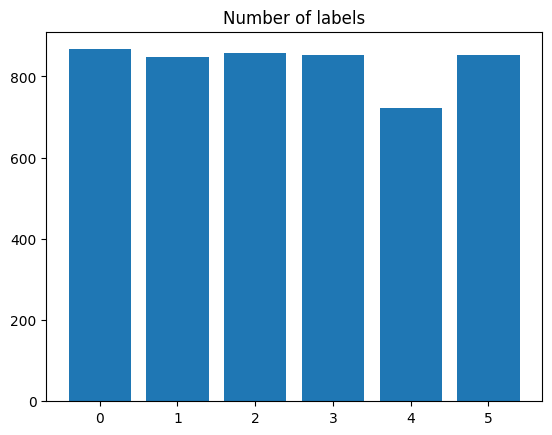

In [ ]:
plt.bar(X, Y)
plt.xticks(X)
plt.title("Number of labels")
plt.show()

In [ ]:
#split dataset

#x에서 8은 포함이 안 된 상태로 0부터 7까지의 index만을 취급
x = train.iloc[:,0:2]
#y에서 8열(Outcome)만을 취함
y = train.iloc[:,2]
x_train, x_test, y_train, y_test = train_test_split(x,y, random_state=0, test_size=0.2)

In [ ]:
y,s = librosa.load('TRAIN_0000.wav')

audio, _ = librosa.effects.trim(y)

plt.figure(figsize = (16, 6))
librosa.display.waveshow(y = audio, sr = s, color = "#00008B");
plt.title("Example Sound Waves on Blues", fontsize = 23);

FileNotFoundError: [Errno 2] No such file or directory: 'TRAIN_0000.wav'

In [ ]:
sc_x = StandardScaler()
x_train = sc_x.fit_transform(x_train)
x_test = sc_x.transform(x_test)

ValueError: could not convert string to float: 'TRAIN_2715'

In [ ]:
classifier = KNeighborsClassifier(n_neighbors = 11, p=2, metric='euclidean')

In [ ]:
# Fit Model

classifier.fit(x_train, y_train)

ValueError: could not convert string to float: 'TRAIN_2715'

In [ ]:
import random
import pandas as pd
import numpy as np
import os
from tqdm.auto import tqdm
import librosa

from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings(action='ignore')

CFG = {
    'SR': 16000, # 샘플링 레이트
    'N_MFCC': 32, # MFCC 벡터를 추출할 개수
    'SEED': 42, # 시드 값
    'N_NEIGHBORS': 5, # KNN에서 사용할 이웃의 수
    'METRIC': 'euclidean' # 거리 측정 방식
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

train_df = pd.read_csv('./train.csv')
test_df = pd.read_csv('./test.csv')

def get_mfcc_feature(df):
    features = []
    for path in tqdm(df['path']):
        # librosa 패키지를 사용하여 wav 파일을 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        # librosa 패키지를 사용하여 MFCC 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])
        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e))
        features.append(y_feature)

    mfcc_df = pd.DataFrame(features, columns=['mfcc_'+str(x) for x in range(1, CFG['N_MFCC']+1)])
    return mfcc_df

train_x = get_mfcc_feature(train_df)
test_x = get_mfcc_feature(test_df)

train_y = train_df['label']

# KNN 모델 정의
model = KNeighborsClassifier(n_neighbors=CFG['N_NEIGHBORS'], metric=CFG['METRIC'])

# 모델 학습
model.fit(train_x, train_y)

# 테스트 데이터 예측
preds = model.predict(test_x)

submission = pd.read_csv('./sample_submission.csv')
submission['label'] = preds
submission.to_csv('./knn_submission.csv', index=False)


  0%|          | 0/5001 [00:00<?, ?it/s]

  0%|          | 0/1881 [00:00<?, ?it/s]

FileNotFoundError: [Errno 2] No such file or directory: './test/TEST_0000.wav'